#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.special import comb

In [2]:
from tqdm import tqdm

#### Generate matrix

In [3]:
N = 10
N2 = N**2
W = np.random.rand(N,N)

In [4]:
def normalize_W(W):
    d1, d2 = W.shape
    wm = np.max(np.abs(W))
    W_prime = np.abs(W)/(wm)
    return W_prime

In [5]:
W_prime = normalize_W(W)

In [6]:
def mst(W_prime=None, Adj=None):
    
    if W_prime is not None:
        d1, d2 = W_prime.shape

        cardV = np.sum(d1+d2)
        cardMST = cardV - 1

    if Adj is None:
        Adj = np.zeros((cardV,cardV))

        for ii in range(d1):
            for jj in range(d2):
                Adj[d1+jj,ii] = W_prime[ii,jj]

        Adj += Adj.T

    cardV, _ = Adj.shape
    cardMST = cardV - 1

    Gr = nx.from_numpy_array(Adj)
    Tr = nx.maximum_spanning_tree(Gr)
    
    d_arr = np.zeros(cardMST).reshape(-1,1)
    c_arr = np.ones(cardMST).reshape(-1,1)

    for kk in range(cardMST):
        d_arr[kk] = sorted(Tr.edges(data=True))[kk][2]['weight']
    
    return Tr, d_arr

In [7]:
Wtree, weights_mst = mst(W_prime)

#### Random bounds

In [8]:
s = 0.1
nSampled = int((1-s)*N2)
nMST = 2*N - 1
n = min(nMST, nSampled)

In [9]:
exp_overlap_random = 0.

for k in range(1,n+1):
    num = comb(nMST,k)*comb(N2-nMST,nSampled-k)
    den = comb(N2,nSampled)
    overlap = k*(num/den)
    exp_overlap_random += overlap

In [10]:
frac_exp_overlap_random = exp_overlap_random/nMST
frac_exp_overlap_random

0.9

In [11]:
def random_bound(s, N):
    nSampled = int((1-s)*N2)
    nMST = 2*N - 1
    n = min(nMST, nSampled)
    
    exp_overlap_random = 0.

    for k in range(1,n+1):
        num = comb(nMST,k)*comb(N2-nMST,nSampled-k)
        den = comb(N2,nSampled)
        overlap = k*(num/den)
        exp_overlap_random += overlap

    frac_exp_overlap_random = exp_overlap_random/nMST
    return frac_exp_overlap_random

In [12]:
def random_prune(A, p):
    
    A += 1e-25
    
    # Ensure p is in the range [0, 1]
    p = max(0, min(1, p))
    # Adjust p based on the sparsity of the original matrix
    p_adjusted = -1.0 + np.sum(A!=0)/np.prod(A.shape) + p
    # Determine the threshold for setting elements to zero
    threshold = 1.0 - p_adjusted
    # Generate a random mask for sparsification
    mask = np.random.random(A.shape)
    # Set mask = 1 where A is already 0 and random elsewhere
    mask = np.where(A==0, 1, mask)
    # Apply the mask to the matrix to sparsify it
    sparsified_matrix = np.where(mask > threshold, A, 0)
    return sparsified_matrix

In [13]:
W_prime_sparse_random = random_prune(W_prime,1-s)

In [14]:
random_overlap = len(np.intersect1d(weights_mst,W_prime_sparse_random.ravel()))/nMST
random_overlap

0.8421052631578947

#### Top-prob bounds

In [15]:
WL1 = np.sum(W_prime)
K = nSampled/WL1

In [16]:
adj_sort = np.sort(W_prime.ravel())[::-1]
adj_argsort = np.argsort(W_prime.ravel())[::-1]

In [17]:
def distribute_equally(arr):
    
    r = np.sum(np.where(arr>1, arr-1, 0))
    
    while r>0:
        # Count number of probs less than 1
        count_less_than_one = sum(1 for num in arr if num < 1)
        # Estimate delta to be added per number
        delta = 0
        if count_less_than_one > 0:
            delta = r/count_less_than_one
        # return new array with delta added appropriately
        arr = np.where(arr<1, arr+delta, 1)
        # calculate new residue
        r = np.sum(np.where(arr>1, arr-1, 0))
    
    return arr

In [18]:
def topprob_probmat(A, s):
    
    N_post = A.shape[0]
    N_pre = A.shape[1]
    A_sparse = np.zeros_like(A)
    
    z0 = np.sum(A==0)
    if z0 > 0:
        z = s*np.prod(A.shape)
        s = (z-z0)/(np.prod(A.shape)-z0)
    
    K = N_pre*N_post*(1-s)/np.sum(np.abs(A))
    Pmat = np.zeros_like(A)
    
    for ii in range(N_post):
        for jj in range(N_pre):
            
            if np.abs(A[ii,jj])>0:
                Pij = K*(np.abs(A[ii,jj]))
                Pmat[ii,jj] = Pij
    
    Pmat_adjusted = distribute_equally(Pmat.ravel())
    Pmat_adjusted = Pmat_adjusted.reshape(N_post, N_pre)
    
    for ii in range(N_post):
        for jj in range(N_pre):
            if np.abs(A[ii,jj])>0:
                Pij = Pmat_adjusted[ii,jj]    
                if np.random.uniform() < Pij:
                    A_sparse[ii,jj] = A[ii,jj]
    
    return Pmat_adjusted, K, A_sparse

In [19]:
sampProb, kappa, W_prime_sparse_topprob = topprob_probmat(W_prime,s)
sampProb = sampProb.ravel()[adj_argsort]

In [20]:
exp_overlap_topprob = 0.

for k in range(1,4):
    exp_overlap_topprob += sampProb[k]
    
# for k in range(4,N2):
#     num = comb(k-1,3)
#     den = (N2 - (k-1))*comb(N2,k-1)
#     exp_overlap_topprob += sampProb[k]*(1 - (num/den))

for k in range(4,N+1):
    num = (N-k)**2
    den = N**2 - k
    exp_overlap_topprob += sampProb[k]*((num/den))

In [21]:
frac_exp_overlap_topprob = exp_overlap_topprob/n
frac_exp_overlap_topprob

0.20840063821585536

In [22]:
topprob_overlap = len(np.intersect1d(weights_mst,W_prime_sparse_topprob.ravel()))/nMST
topprob_overlap

1.0

In [23]:
def topprob_bounds(s,W_prime):
    
    N = W_prime.shape[0]
    
    nSampled = int((1-s)*N2)
    nMST = 2*N - 1
    n = min(nMST, nSampled)
    
    if n==0:
        n += 1e-20
    
    adj_sort = np.sort(W_prime.ravel())[::-1]
    adj_argsort = np.argsort(W_prime.ravel())[::-1]
    
    sampProb, _, _ = topprob_probmat(W_prime,s)
    sampProb = sampProb.ravel()[adj_argsort]
    
    exp_overlap_topprob = 0.

    for k in range(1,4):
        exp_overlap_topprob += sampProb[k]

    for k in range(4,N+1):
        num = (N-k)**2
        den = N**2 - k
        exp_overlap_topprob += sampProb[k]*((num/den))
        
    frac_exp_overlap_topprob = exp_overlap_topprob/n
    return frac_exp_overlap_topprob

In [24]:
topprob_bounds(1,W_prime)

0.0

#### Simulations

In [25]:
s_levels = np.linspace(0,1,21)
s_levels

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [26]:
N_levels = [10,50,100]

In [27]:
topprobs_emp = np.zeros((len(s_levels),len(N_levels))).T
random_emp = np.zeros((len(s_levels),len(N_levels))).T

for iii, NN in tqdm(enumerate(N_levels)):
    Wp = np.random.rand(NN,NN)
    Wp = normalize_W(Wp)
    Wptree, Wp_mst = mst(Wp)
    
    for jjj, ss in enumerate(s_levels):
        _, _, Wp_sparse_topprob = topprob_probmat(Wp,ss)
        Wp_sparse_random = random_prune(Wp,1-ss)
        topprobs_emp[iii,jjj] = len(np.intersect1d(Wp_mst,Wp_sparse_topprob.ravel()))/len(Wp_mst)
        random_emp[iii,jjj] = len(np.intersect1d(Wp_mst,Wp_sparse_random.ravel()))/len(Wp_mst)

3it [00:01,  1.62it/s]


In [28]:
topprobs_th = np.zeros((len(s_levels),1)).T
random_th = np.zeros((len(s_levels),1)).T

for iii, NN in tqdm(enumerate([N_levels[0]])):
    Wp = np.random.rand(NN,NN)
    Wp = normalize_W(Wp)
    Wptree, Wp_mst = mst(Wp)
    
    for jjj, ss in enumerate(s_levels):
        topprobs_th[iii,jjj] = topprob_bounds(ss,Wp)
        random_th[iii,jjj] = random_bound(ss,NN)

1it [00:00, 34.48it/s]


Text(0.5, 1.0, 'Overlap with MST')

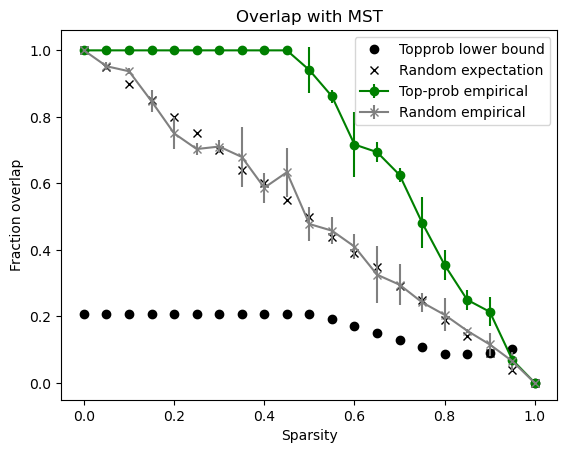

In [29]:
fbound = plt.figure()
plt.plot(s_levels,np.mean(topprobs_th,0), 'o',color='k',label='Topprob lower bound')
plt.plot(s_levels,np.mean(random_th,0), 'x',color='k',label='Random expectation')

plt.errorbar(s_levels,np.mean(topprobs_emp,0), yerr=np.std(topprobs_emp,0), fmt='-o',color='g',label='Top-prob empirical')
plt.errorbar(s_levels,np.mean(random_emp,0), yerr=np.std(random_emp,0), fmt='-x',color='grey',label='Random empirical')

plt.legend()
plt.xlabel('Sparsity')
plt.ylabel('Fraction overlap')
plt.title('Overlap with MST')

In [30]:
fbound.savefig('pruning-overlap-bounds-empirical.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


#### Distribution of non-zero weights

In [78]:
import seaborn as sns

In [118]:
# plt.imshow(Wp,cmap='binary_r')
# plt.clim(0,1)
# plt.colorbar()

In [111]:
sp = 0.9
Wp_sparse_random = random_prune(Wp,1-sp)
_, _, Wp_sparse_topprob = topprob_probmat(Wp,sp)

In [112]:
# plt.imshow(Wp_sparse_random,cmap='binary_r')
# plt.clim(0,1)
# plt.colorbar()

In [113]:
# plt.imshow(Wp_sparse_topprob,cmap='binary_r')
# plt.clim(0,1)
# plt.colorbar()

Text(0.5, 1.0, 'Distribution of non-zero weights')

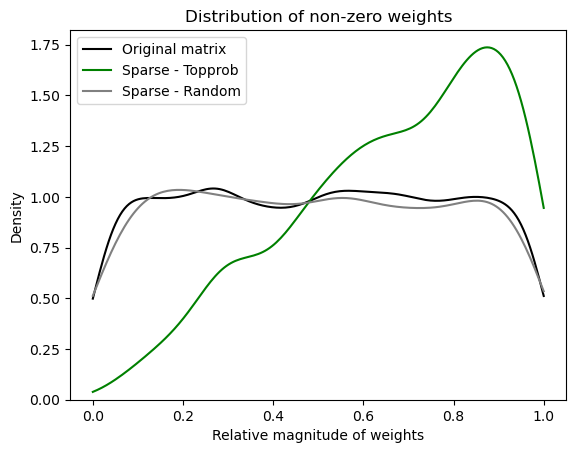

In [117]:
fdist = plt.figure()
xmin = 0
xmax = 1
sns.kdeplot(Wp.ravel(),label='Original matrix',clip=(xmin, xmax),color='k',
            common_norm=True,common_grid=True)

Wp_sp_tppb = Wp_sparse_topprob.ravel()
Wp_sp_tppb = Wp_sp_tppb[Wp_sp_tppb != 0]
sns.kdeplot(Wp_sp_tppb.ravel(), label='Sparse - Topprob',clip=(xmin, xmax),color='g',
            common_norm=True, common_grid=True)

Wp_sp_rndm = Wp_sparse_random.ravel()
Wp_sp_rndm = Wp_sp_rndm[Wp_sp_rndm != 0]
sns.kdeplot(Wp_sp_rndm.ravel(), label='Sparse - Random',clip=(xmin, xmax),color='grey',
            common_norm=True, common_grid=True)
plt.legend()
plt.xlabel('Relative magnitude of weights')
plt.title('Distribution of non-zero weights')

In [115]:
fdist.savefig('distribution-nnz-weights.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [106]:
# plt.figure()
# xmin = 0
# xmax = 1
# sns.histplot(Wp.ravel(),label='Original matrix',color='k',kde=True)
# sns.histplot(Wp_sp_tppb.ravel(), label='Sparse - Topprob',color='g',kde=True)
# sns.histplot(Wp_sp_rndm.ravel(), label='Sparse - Random',color='grey',kde=True)
# plt.legend()
# plt.xlabel('Relative magnitude of weight')